### Introduction
In this project, we will learn the techniques for proximity analysis of geospatial data.
- How to measure distance between points on a map
- How to select all points within some radius of a feature


In [36]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker, GeoJson
from folium.plugins import HeatMap, MarkerCluster
# !pip install geojson
import geojson

In [2]:
# Loading data of toxic chemical releases in Philadelphia, Pennsylvania
releases = gpd.read_file(r'C:\Users\Rabbil\Documents\GeoPython\GeoSpatial_Analysis\toxic_release_pennsylvania\toxic_release_pennsylvania\toxic_release_pennsylvania.shp')
releases.head()

,YEAR,CITY,COUNTY,ST,LATITUDE,LONGITUDE,CHEMICAL,UNIT_OF_ME,TOTAL_RELE,geometry
0,2016,PHILADELPHIA,PHILADELPHIA,PA,40.005901,-75.072103,FORMIC ACID,Pounds,0.160,POINT (2718560.227 256380.179)
1,2016,PHILADELPHIA,PHILADELPHIA,PA,39.920120,-75.146410,ETHYLENE GLYCOL,Pounds,13353.480,POINT (2698674.606 224522.905)
2,2016,PHILADELPHIA,PHILADELPHIA,PA,40.023880,-75.220450,CERTAIN GLYCOL ETHERS,Pounds,104.135,POINT (2676833.394 261701.856)
3,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,LEAD COMPOUNDS,Pounds,1730.280,POINT (2684030.004 221697.388)
4,2016,PHILADELPHIA,PHILADELPHIA,PA,39.913540,-75.198890,BENZENE,Pounds,39863.290,POINT (2684030.004 221697.388)


In [3]:
# loading data: readings from air quality monitoring stations for the same city
stations = gpd.read_file(r'C:\Users\Rabbil\Documents\GeoPython\GeoSpatial_Analysis\PhillyHealth_Air_Monitoring_Stations\PhillyHealth_Air_Monitoring_Stations\PhillyHealth_Air_Monitoring_Stations.shp')
stations.head()

,SITE_NAME,ADDRESS,BLACK_CARB,ULTRAFINE_,CO,SO2,OZONE,NO2,NOY_NO,PM10,...,PAMS_VOC,TSP_11101,TSP_METALS,TSP_LEAD,TOXICS_TO1,MET,COMMUNITY_,LATITUDE,LONGITUDE,geometry
0,LAB,1501 East Lycoming Avenue,N,N,Y,N,Y,Y,Y,N,...,Y,N,Y,N,y,N,N,40.008606,-75.097624,POINT (2711384.641 257149.310)
1,ROX,Eva and Dearnley Streets,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,40.050461,-75.236966,POINT (2671934.290 271248.900)
2,NEA,Grant Avenue and Ashton Street,N,N,N,N,Y,N,N,N,...,N,N,N,N,N,Y,N,40.072073,-75.013128,POINT (2734326.638 280980.247)
3,CHS,500 South Broad Street,N,N,N,N,N,N,N,N,...,N,N,Y,N,Y,N,N,39.944510,-75.165442,POINT (2693078.580 233247.101)
4,NEW,2861 Lewis Street,N,N,Y,Y,Y,N,Y,Y,...,N,Y,N,Y,N,Y,N,39.991688,-75.080378,POINT (2716399.773 251134.976)


### Measuring distance

- First, we have to make sure that both geodataframes use same coordinate reference system (CRS)


In [4]:
# let's check the crs
print(releases.crs)
print(stations.crs)

epsg:2272
epsg:2272


- epsg 2272 has units of feet

In [7]:
# select one release incident in particular from where we measure the distance
recent_release = releases.iloc[2]
#recent_release

# Measure the distance from recent_release to each station of stations geodataframe
distances = stations.geometry.distance(recent_release.geometry)
distances

0     34849.883025
1     10730.669379
2     60639.339594
3     32765.517627
4     40953.111043
5     37987.448605
6     31533.228750
7     50586.479975
8     67195.495782
9     41640.381151
10    13243.497038
11    32588.286810
dtype: float64

In [8]:
# from this calcuated distances, we can have mean distance to each station

print('Mean distance to monitoring stations: {} feet'.format(distances.mean()))

Mean distance to monitoring stations: 37892.77823150555 feet


In [15]:
# We can get the closest monitoring station

print('Closest monitoring stations ({} feet):'.format(distances.min()))

print(stations.iloc[distances.idxmin()][['ADDRESS','LATITUDE', 'LONGITUDE']])

Closest monitoring stations (10730.66937892791 feet):
ADDRESS      Eva and Dearnley Streets
LATITUDE                      40.0505
LONGITUDE                     -75.237
Name: 1, dtype: object


### Creating a buffer

- For all points on a map that are some radius away from a point, we create a buffer

In [16]:
# let's create a GeoSereis called two_mile_buffer
two_mile_buffer = stations.geometry.buffer(2*5280)
two_mile_buffer

0     POLYGON ((2721944.641 257149.310, 2721893.792 ...
1     POLYGON ((2682494.290 271248.900, 2682443.441 ...
2     POLYGON ((2744886.638 280980.247, 2744835.789 ...
3     POLYGON ((2703638.580 233247.101, 2703587.731 ...
4     POLYGON ((2726959.773 251134.976, 2726908.924 ...
5     POLYGON ((2697782.449 225162.647, 2697731.600 ...
6     POLYGON ((2709637.969 239351.837, 2709587.120 ...
7     POLYGON ((2688745.661 211133.454, 2688694.812 ...
8     POLYGON ((2753330.481 274645.396, 2753279.631 ...
9     POLYGON ((2698367.072 221533.464, 2698316.223 ...
10    POLYGON ((2691452.753 249095.833, 2691401.904 ...
11    POLYGON ((2707903.868 236377.621, 2707853.019 ...
dtype: geometry

- So we see that the two_mile_buffer contain 12 different polygon objects
- Each polygon is a buffer of 2 miles (2*5280 feet) around monitoring stations

In [37]:
# Let's plot the ploygon on a map
# Before plotting, we have to convert the CRS to epsg 4326 becuase
# we will use folium.GeoJson() method and it requires coordinates in latitude and logitude

m = folium.Map(location=[40.0505,-75.237], zoom_start=11)

HeatMap(data=releases[['LATITUDE', 'LONGITUDE']], radius=15).add_to(m)

for idx, row in stations.iterrows():
    folium.Marker([row['LATITUDE'], row['LONGITUDE']]).add_to(m)

# Plot each polygon on the map
GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)
# show the map
m

Now, to test if a toxic release occurred within 2 miles of any monitoring station, we could run 12 different tests for each polygon (to check individually if it contains the point).

But a more efficient way is to first collapse all of the polygons into a MultiPolygon object. We do this with the unary_union attribute.


Type: <class 'shapely.geometry.multipolygon.MultiPolygon'>


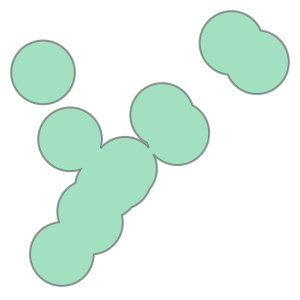

In [29]:
# Turn group of polygon into single multipolygon
my_union = two_mile_buffer.geometry.unary_union
print('Type:', type(my_union))

# Show the Multiploygon object
my_union

- Now we will use contains() method to check if the multipolygon contains a point


In [34]:
# The closest stations is more than two miles away
my_union.contains(releases.iloc[2].geometry)

False

In [35]:
# The closest stations is less than two miles away
my_union.contains(releases.iloc[7].geometry)

True